In [13]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [14]:
%matplotlib inline

# Read the SN data

In [15]:
data = np.genfromtxt("SCPUnion2.1_mu_vs_z.txt", 
                     skip_header=5, 
                     names=['snname', 'redshift', 'distancemod', 'errordistancemod', 'problowmass'], 
                     dtype=None)

Plot data with errorbar

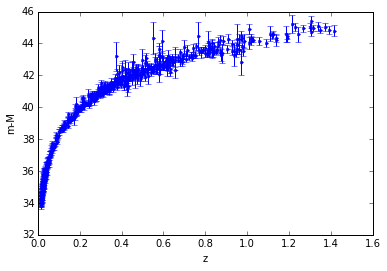

In [16]:
plt.errorbar(data['redshift'], data['distancemod'], yerr=data['errordistancemod'], fmt='.')
plt.xlabel('z')
plt.ylabel('m-M')

# Overplot with the equation

Distance modulus define by

$m - M = 5 \log_{10} \left( \frac{d_L}{1 \text{Mpc}} \right) + 25$

## when $z \ll 1$ 
luminosity distance is

$d_L \approx \frac{c}{H_0} z \left( 1 + \frac{1 - q_0}{2} z \right)$

or

$m - M \approx 43.17 - \log_{10} \left( \frac{H_0}{70 \text{km/s/Mpc}} \right) + 5 \log_{10}{z} + 1.086\log_{10}(1 - q_0)z $

with

$q_0 =  \Omega_{r,0} + \frac{1}{2} \Omega_{m,0} - \Omega_{\Lambda,0}$

In [17]:
def distancemodulus(H0, redshift, q):
    return 43.17 - np.log10(H0/70) + 5*np.log10(redshift) + 1.086*np.log10(1 - q)*data['redshift']

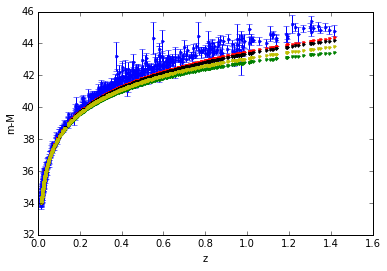

In [18]:
distmod1 = distancemodulus(70, data['redshift'], 0.5) # Omega_m = 1
distmod2 = distancemodulus(70, data['redshift'], -1.0) # Omega_v = 1
distmod3 = distancemodulus(70, data['redshift'], -0.55) # Benchmark
distmod4 = distancemodulus(70, data['redshift'], 0.15) # Omega_m = 0.3
plt.errorbar(data['redshift'], data['distancemod'], yerr=data['errordistancemod'], fmt='.')
plt.plot(data['redshift'], distmod1, 'g.') # green
plt.plot(data['redshift'], distmod2, 'r.') # red
plt.plot(data['redshift'], distmod3, 'k.') # black
plt.plot(data['redshift'], distmod4, 'y.') # yellow
plt.xlabel('z')
plt.ylabel('m-M')

You see something strange? :D

## With full Friedmann model

Luminosity distance is

$d_L = d_p(t_0) (1 + z)$

and  proper distance is

$d_p(t) = a(t) \int_0^{r} dr = a(t) \cdot r = a(t) \cdot c \int_{t_e}^{t_o} \frac{dt}{a(t)}$

From Friedmann model

$\dot{a} = \frac{da}{dt} = H_0 \sqrt{\Omega_{r,0}/a^2 + \Omega_{m,0}/a + \Omega_{\Lambda,0}a^2 + (1 - \Omega_{0})}$

Proper distance at the time of observation

$d_p (t) = a(t) \cdot c \int \frac{dt}{a(t)}$

$d_p (t) = a(t) \cdot c \int \frac{da}{a H_0 \sqrt{\Omega_{r,0}/a^2 + \Omega_{m,0}/a + \Omega_{\Lambda,0}a^2 + (1 - \Omega_{0})}}$

$d_p(t_0) = \frac{c}{H0} \int_{a_e}^{a_0} \frac{da}{a \sqrt{\Omega_{r,0}/a^2 + \Omega_{m,0}/a + \Omega_{\Lambda,0}a^2 + (1 - \Omega_{0})} }$

We can use <code>scipe.integrate </code> to do integration

In [19]:
import scipy.integrate as integrate

c = 299792.458 # speed of light in km/s
def cosmos_at_z(z, H0, w_r, w_m, w_v):
    w_k = 1.0 - w_m - w_r - w_v # calculate Omega curvature (1 - Omega(total))
    az = 1.0/(1.0 + z) # scale factor of a given z


    # calculate time from z to now, and comoving radial distance
    a_dot = lambda a: 1.0/(a*np.sqrt(w_k + w_m/a + w_r/(a*a) + w_v*a*a))
    dcmr , err = integrate.quad(a_dot, az, 1.0) # a_obs = 1.0
    dl = dcmr*(1+z)
    dl_mpc = (c/H0)*dl

    return dl_mpc

### Let's try benchmark model (again)

In [20]:
H0 = 70.0
h = H0/100.0
w_r = 4.165E-5/(h*h)
w_m = 0.3
w_v = 0.7
d_L = []
for i in data['redshift']: d_L.append(cosmos_at_z(i, H0, w_r, w_m, w_v))
d_L = np.array(d_L)
distmod = 5.0*np.log10(d_L) + 25.0

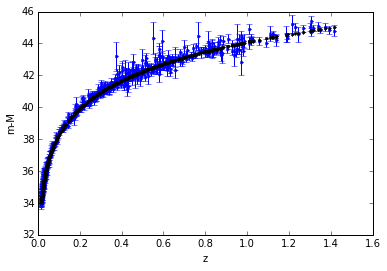

In [21]:
plt.errorbar(data['redshift'], data['distancemod'], yerr=data['errordistancemod'], fmt='.')
plt.plot(data['redshift'], distmod, 'k.')
plt.xlabel('z')
plt.ylabel('m-M')

That's better!

# Fitting

In [22]:
from scipy.optimize import curve_fit

In [23]:
# write a function that we want to fit in our data -> distance modulus as a function of z
def func(z, w_m, w_v): # z is numpy array
    # we know the value w_r from CMB and CNB
    H0 = 70.0
    w_r = 8.5E-5
    d_l = []
    for zi in z: d_l.append(cosmos_at_z(zi, H0, w_r, w_m, w_v)) # calculate luminosity distance from z value
    d_l = np.array(d_l)
    distmod = 5.0*np.log10(d_l) + 25.0 # calculate distance modulus from luminosity distance
    return distmod

In [24]:
popt, pcov = curve_fit(func, data['redshift'], data['distancemod'], sigma=data['errordistancemod'])
print "Omega_m = ", popt[0], "Omega_v = ", popt[1]

Omega_m =  0.281008770334 Omega_v =  0.725159371407


*nice!*